In [1]:
from DC import DCModel
from FLORIS_PT import FLORIS_PT
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mplcolors
import copy
plt.rcParams.update({'font.size': 16})

## FLORIS-PT and DC

### Shared inputs

In [2]:
# input files to define turbine type, wind conditions, and FLORIS model parameters
input_file_path = "./inputs.yaml"
floris_pt = FLORIS_PT(input_file_path)

# wind farm layout
D = floris_pt.turbine['rotor_diameter']
x_coord = torch.tensor([0., 6.*D,
                        0., 6.*D])
y_coord = torch.tensor([3.*D, 3.*D, 
                        0., 0.])
z_hh = floris_pt.turbine['hub_height']
nturbs = len(x_coord)
z_coord = torch.tensor([z_hh] * nturbs)

## FLORIS-PT

### FLORIS-PT inputs

In [3]:
wd = torch.tensor([269.5]) # degrees
ws = torch.tensor([8.0]) # m/s
scaled_u = torch.tensor([25., 0., 25., 0.]) # yaw angles for each turbine in farm

### Power and velocity given control action

In [4]:
# generate mesh on turbine rotor
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

# get control action
scaled_u_sorted = scaled_u[inds_sorted]

# calculate field on rotor mesh
flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted)

# calculate turbine power
p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)

# print individual turbine power, farm power, and velocity
print("turbine power: ", np.round(p.detach().numpy().flatten(), 0)) # kW
print("farm power: ", np.round(torch.sum(p).detach().numpy(), 0)) # kW
print("velocity: ", flow_field_u.detach().numpy()[0]) # m/s

turbine power:  [1406. 1406.  862.  862.]
farm power:  4536.0
velocity:  [[[7.596956  8.        8.293351 ]
  [7.596956  8.        8.293351 ]
  [7.596956  8.        8.293351 ]]

 [[7.596956  8.        8.293351 ]
  [7.596956  8.        8.293351 ]
  [7.596956  8.        8.293351 ]]

 [[5.4542837 5.216503  5.9542656]
  [6.0214705 5.953323  6.573445 ]
  [6.8960876 7.0895185 7.5282364]]

 [[5.4542837 5.216503  5.9542656]
  [6.0214715 5.9533243 6.573446 ]
  [6.8960886 7.0895195 7.5282373]]]


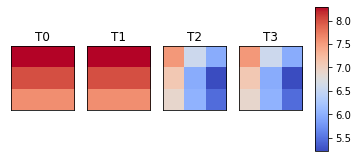

In [5]:
# plotting settings
t_range = None
index = 0
n_rows = 1
n_cols = 4
cmap = "coolwarm"
save_path = False

#plot rotor values
cmap = plt.cm.get_cmap(name=cmap)
if t_range is None:
    t_range = range(flow_field_u.shape[1])
    
fig = plt.figure()
axes = fig.subplots(n_rows, n_cols)

indices = t_range
titles = np.array([f"T{i}" for i in indices])

for ax, t, i in zip(axes.flatten(), titles, indices):
    vmin = torch.min(flow_field_u[index])
    vmax = torch.max(flow_field_u[index])

    bounds = np.linspace(vmin, vmax, 31)
    norm = mplcolors.Normalize(vmin, vmax)

    ax.imshow(flow_field_u[0, i].T, cmap=cmap, norm=norm, origin="lower")
    ax.invert_xaxis()

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(t)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.25, 0.03, 0.5])
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)

plt.show()

## DC

### Helper functions to apply DC to FLORIS-PT

In [6]:
# get control action from DC model
def get_control(model, ws, inds_sorted, ws_min, ws_max, active_turbs=None):
    # normalize features to range [0,1]
    ws_rep = ws.unsqueeze(dim=1)
    ws_norm = (ws_rep - ws_min)/(ws_max - ws_min)
    if active_turbs is not None:
        x = torch.cat([ws_norm, active_turbs], axis=1)
    else:
        x = ws_norm
    u = model(x)
    scaled_u = torch.clone(u)*(umax-umin)+umin
    if active_turbs is not None:
        scaled_u = torch.where(active_turbs,scaled_u,torch.tensor(0.))
    scaled_u = torch.reshape(scaled_u, (x.shape[0], nturbs, 1, 1)) # unflatten
    scaled_u_sorted = torch.take_along_dim(scaled_u, inds_sorted, axis=1) # sort
    return scaled_u_sorted, scaled_u, u

# calculate average power over list of wind speeds
# modifies powers list to add this average power
def test_power(floris_pt, model, ws_validation, wd_validation, powers_validation, \
    x_coord, y_coord, z_coord, ws_max, wd_max=360., active_turbs_validation=None):
    
    ws = ws_validation
    wd = wd_validation.repeat(ws_validation.shape[0])

    # generate mesh on turbine rotor
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted = \
        floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

    # get control action
    scaled_u_sorted, _, u = get_control(model, ws, inds_sorted, ws_min, ws_max)

    # calculate field on rotor mesh
    flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted)

    # calculate turbine power
    p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)

    # add farm power
    farm_power = torch.sum(p, dim=(1)) # sum over turbines
    farm_power_mean = torch.mean(farm_power).item()

    power_validation = farm_power_mean
        
    powers_validation.append(power_validation/nturbs)

###  DC inputs

In [7]:
# dropout
dropout = False

# set bounds on allowed yaw angle
umin = torch.tensor([-25.]) # minimum allowed yaw angle (degrees)
umax = torch.tensor([25.]) # maximum allowed yaw angle (degrees)

# hyperparameters
lr = .001
batch_size = 20
N_batches = 10
N_epochs = 10
hidden_dim = 64

# neural network parameters
model_config = dict({"n_turbines": nturbs, 
                     "hidden_dim": hidden_dim,
                     "dropout": dropout})

# generate training data
ws_max = 11.4
ws_min = 3.0
wd_fixed = 270.
ws_training = torch.rand((N_batches, batch_size, 1)) * (ws_max - ws_min) + ws_min
wd_training = wd_fixed + .1*(torch.rand((N_batches, batch_size, 1)) -.5) # wd varies around wd_fixed; degrees

# pick validation set
ws_validation = torch.tensor([4., 6., 8.]) # m/s
wd_validation = torch.tensor([wd_fixed]) # degrees

### Training

In [8]:
# initialize DC model
model = DCModel(**model_config)

# initialize optimizer used for training
opt = torch.optim.Adam(model.parameters(), lr=lr)

# vectors to track training progress
opt_losses = []
powers_validation = []

# calculate and record power over validation set 
# using control actions from untrained DC policy
test_power(floris_pt, model, ws_validation, wd_validation, powers_validation, \
           x_coord, y_coord, z_coord, ws_max)

power_best = powers_validation[-1]
model_best = copy.deepcopy(model)

for epoch in range(N_epochs):
    # reorder samples to randomize data in batches
    perm_i = torch.randperm(N_batches)
    perm_j = torch.randperm(batch_size)
    ws_training_ij = ws_training[perm_i][:,perm_j]
    wd_training_ij = wd_training[perm_i][:,perm_j]

    for batch in range(N_batches):
        opt_loss = 0.

        # forward pass
        ws = ws_training_ij[batch, :].squeeze(dim=1)
        wd = wd_training_ij[batch, :].squeeze(dim=1)

        # generate mesh on turbine rotor
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted = \
            floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

        # get control action
        scaled_u_sorted, _, u = get_control(model, ws, inds_sorted, ws_min, ws_max)

        # calculate field on rotor mesh
        flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted)

        # calculate turbine power
        p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)

        # negative farm power (negative b/c optimizer minimizes loss)
        power_cost = -torch.sum(p)

        # sum over samples in batch
        opt_loss += power_cost/nturbs

        # normalize loss by batch size
        opt_loss /= batch_size

        # backward pass
        opt.zero_grad()
        opt_loss.backward()
        opt.step()
        
        # save losses
        opt_losses.append(opt_loss.detach().numpy())

        # calculate and record power over validation set 
        # using control actions from updated DC policy
        test_power(floris_pt, model, ws_validation, wd_validation, powers_validation, \
               x_coord, y_coord, z_coord, ws_max)
        
        # save best model
        power_validation = powers_validation[-1]
        if power_validation > power_best:
            power_best = power_validation
            model_best = copy.deepcopy(model)
            
model = model_best

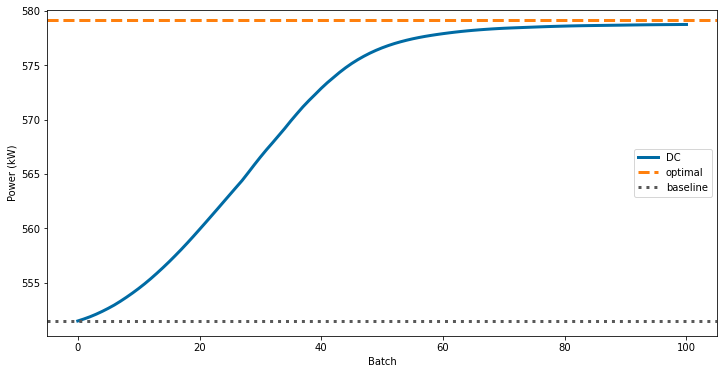

In [9]:
# power for validation set from FLORIS model (baseline and optimized)
FLORIS_baseline = (4483. + 1771. + 364.)/nturbs/3. # unyawed; from FLORIS
FLORIS_opt = (4662. + 1882. + 406.)/nturbs/3. # optimal yaw; from FLORIS

plt.style.use('tableau-colorblind10')                                                          
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.plot(np.array(powers_validation), label='DC', color=colors[0], linestyle='-', linewidth=3)
plt.axhline(FLORIS_opt, label='optimal', color=colors[1], linestyle='--', linewidth=3)
plt.axhline(FLORIS_baseline, label='baseline', color=colors[3], linestyle=':', linewidth=3)
plt.legend()
plt.xlabel('Batch')
plt.ylabel('Power (kW)')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

### Testing

In [10]:
ws = torch.tensor([ws_max])
wd = torch.tensor([wd_fixed])

# generate mesh on turbine rotor
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

# get control action
u_DC, _, _ = get_control(model, ws, inds_sorted, ws_min, ws_max)
u_optimal = torch.tensor([25., 0., 25., 0.])[inds_sorted] # optimal yaw; from FLORIS
u_baseline = torch.tensor([0., 0., 0., 0.])[inds_sorted] # unyawed

# compare DC control action to optimal action (from FLORIS) 
# and baseline action (unyawed)
us = [u_DC, u_optimal, u_baseline]
labels = ["DC", "optimal", "baseline"]
for i in range(len(us)):    
    u = us[i]
    # calculate field on rotor mesh
    flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, u, \
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted)

    # calculate turbine power
    p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)
    
    label = labels[i]
    print(label + " yaw: ", np.round(u.detach().numpy().flatten(),1))
    print(label + " power: ", np.round(torch.sum(p).detach().numpy(), 1))
    print("")

DC yaw:  [24.5 24.6  0.1  0.3]
DC power:  13505.3

optimal yaw:  [25. 25.  0.  0.]
optimal power:  13503.5

baseline yaw:  [0. 0. 0. 0.]
baseline power:  13141.6

